In [42]:
import datetime
import nltk
import pandas as pd
import numpy as np
import pickle
import pymongo
import random
import seaborn as sns
import string
import lda
import re
import time

from collections import defaultdict, Counter
from os import path

## NLP
from nltk.corpus import treebank, stopwords
from nltk import bigrams, trigrams
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
from sklearn.neighbors import kneighbors_graph

from textblob import TextBlob

from gensim import corpora, models, similarities

import lda.datasets

## Database
from pymongo import MongoClient

## Visualization
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

%matplotlib inline
# %pylab inline


In [43]:
def pickleme(temp, filename):
    
    with open(filename + '.pkl', 'w') as picklefile:
        pickle.dump(temp, picklefile)
    
    return

In [44]:
def getpickle(filename):

    try:
        with open(filename + '.pkl', 'rb') as picklefile:
            return pickle.load(picklefile)
    except:
        return 'There was an error trying to read this file.  Please check the filename or path.'

In [45]:
def tokenizenstem(temp, stem = True, nouns = False):
    
    global stopwords
    
    temptokens = []
    
    if nouns:
        blob = TextBlob(temp)
        tokens = blob.noun_phrases
    else:
        tokens = nltk.word_tokenize(temp)
    
    ##  Creates instance of WordNetLemmatizer
    wnl = WordNetLemmatizer()
    
    for word in tokens:
        if word.lower() not in stopwords and word not in string.punctuation and len(word) > 2:# and re.search('[a-zA-Z]', word):
            if stem:
                temptokens.append(wnl.lemmatize(word.lower()))
            else:
                temptokens.append(word.lower())
    
    return temptokens

In [46]:
def cloud(tokens, maxwords):
    
    global STOP_WORDS, colors
    
    wordcloud = WordCloud(height = 500, width = 700, 
                          background_color = 'white', mode = 'RGBA', 
                          max_words = maxwords, stopwords = STOP_WORDS,
                          margin = 10, random_state = 3).generate(tokens)
    plt.figure()

    plt.imshow(wordcloud.to_array())
#     plt.imshow(wordcloud.recolor(color_func = grey_color_func, random_state=3))
    plt.axis("off")
    plt.show()
    
    return

In [47]:
STOP_WORDS = getpickle('stopwords')
colors = getpickle('tableaucolors')

### Start-up mongoDB and load resume database

Connect to the mongoDB server with mongo.
```
help
show dbs
use new_cool_db
show dbs
```

In [7]:
! brew services start mongodb

Service `mongodb` already started, use `brew services restart mongodb` to restart.


In [8]:
# ! brew services stop mongodb

In [9]:
## Initialize MongoDB for use
client = MongoClient()
db = client['resume_db']
resumes = db.resume_collection

In [48]:
print "Count of number of documents:", resumes.count()
print "Keys in one example document:", resumes.find_one().keys()
# resumes.find_one() # Uncomment this line to see what a full document looks like.

Count of number of documents: 75
Keys in one example document: [u'Languages', u'Education', u'Name', u'Clearance', u'Countries', u'Skills', u'Resume', u'Polygraph', u'Experience', u'Tokens', u'Phone', u'Date', u'Military', u'_id', u'Email']


In [51]:
corpus = []
tokens = []

for resume in resumes.find({}, {'Resume' : 1, "_id": 0}):
    corpus.append(resume['Resume'])
#     tokens.append(tokenizenstem(resume['Resume'], stem = True, nouns = False))

print len(corpus), len(tokens)

75 0


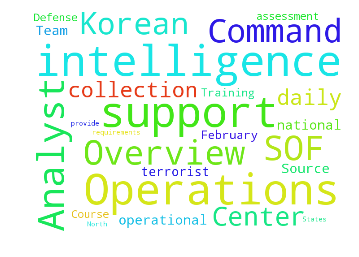

In [52]:
cloud(corpus[8], 25)

## Counter / Word Frequency Analysis

In [53]:
count = Counter(tokens[0])
count.most_common(10)
# sorted(count)

IndexError: list index out of range

### Find the Euclidean Distance between Resumes

In [54]:
vectorizer = CountVectorizer()

wookie = vectorizer.fit_transform(corpus)

In [55]:
wookie.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 2, 0, ..., 0, 0, 0]])

In [56]:
jsondata = pairwise_distances(wookie, metric = 'euclidean')

In [57]:
jsondata

array([[   0.        ,   81.27115109,   79.0569415 , ...,   88.98876334,
          87.25823743,   70.73895674],
       [  81.27115109,    0.        ,   33.48133809, ...,  110.96846399,
         124.06852945,   68.19824045],
       [  79.0569415 ,   33.48133809,    0.        , ...,  106.40018797,
         113.46365057,   67.79380503],
       ..., 
       [  88.98876334,  110.96846399,  106.40018797, ...,    0.        ,
          99.62429423,   95.04209594],
       [  87.25823743,  124.06852945,  113.46365057, ...,   99.62429423,
           0.        ,  106.83632341],
       [  70.73895674,   68.19824045,   67.79380503, ...,   95.04209594,
         106.83632341,    0.        ]])

In [60]:
df = pd.DataFrame(jsondata)
df['index'] = np.array(range(0,75))

In [95]:
for i in range(75):
    temp = df[['index', i]].sort_values(i)[1:2]
    tempindex = str(temp['index'])
    print '{\"source\":' + str(i + 1) + ',\"target\":' + tempindex + ',\"value\":' + str(1) + '},'
    temp = df[['index', i]].sort_values(i)[2:3]
    tempindex = str(temp['index'])
    print '{\"source\":' + str(i + 1) + ',\"target\":' + tempindex + ',\"value\":' + str(1) + '},'
    

{"source":0,"target":16    16
Name: index, dtype: int64,"value":1},
{"source":0,"target":59    59
Name: index, dtype: int64,"value":1},
{"source":1,"target":55    55
Name: index, dtype: int64,"value":1},
{"source":1,"target":15    15
Name: index, dtype: int64,"value":1},
{"source":2,"target":55    55
Name: index, dtype: int64,"value":1},
{"source":2,"target":1    1
Name: index, dtype: int64,"value":1},
{"source":3,"target":11    11
Name: index, dtype: int64,"value":1},
{"source":3,"target":12    12
Name: index, dtype: int64,"value":1},
{"source":4,"target":1    1
Name: index, dtype: int64,"value":1},
{"source":4,"target":15    15
Name: index, dtype: int64,"value":1},
{"source":5,"target":55    55
Name: index, dtype: int64,"value":1},
{"source":5,"target":2    2
Name: index, dtype: int64,"value":1},
{"source":6,"target":37    37
Name: index, dtype: int64,"value":1},
{"source":6,"target":56    56
Name: index, dtype: int64,"value":1},
{"source":7,"target":55    55
Name: index, dtype: int6

In [35]:
# for i in range(75):
#     for j in df.iterrows():
#         print i, j
        
    
#     tempdf = sorted(df[i])[:6]
#     for j in range(6):
#         if tempdf[j] == 0:
#             continue
#         else:
# #             index = df[df[tempdf[j]] == True].index
#             print i, j, int(tempdf[j]//10)

In [1333]:
print sorted(df[i])[:6]

[0.0, 57.30619512757761, 58.677082408722406, 58.80476171195663, 58.838762733422598, 59.657354953098618]


In [1325]:
tempdf.sort_values(axis=1, ascending=True)

TypeError: sort_values() takes at least 2 arguments (3 given)

In [1276]:
def writejson(temp):
    
    f = open('resumes.json', 'w')
    
    f.write('{\n  "nodes":[\n')
    
    for i in range(75):
        filename = '0' * (3 - len(str(i + 1))) + str(i + 1)
        f.write('    {\"name\":\"Resume ' + filename + '",\"group\":' + str(1) +'},\n')
    
    f.write('  ],\n  \"links\":[\n')
    
    for i,resume in enumerate(jsondata.tolist()):
        for j,distance in enumerate(resume):
            filename = '0' * (3 - len(str(i + 1))) + str(i + 1)
            if distance != 0 and distance < 50 :
#                 f.write(str(i + 1)+ ', ' + str(j + 1) + ', ' + str(distance) + '\n')
#                 f.write('{\"source\":' + str(i + 1) + ',\"target\":' + str(j + 1) + ',\"value\":' + str((distance)) + '},\n')
                f.write('    {\"source\":' + str(i + 1) + ',\"target\":' + str(j + 1) + ',\"value\":' + str(1) + '},\n')
    
    f.write('  ]\n}')
    f.close()
    

In [1277]:
writejson(jsondata.tolist())

In [104]:
end = 75

for i,resume in enumerate(jsondata.tolist()):
    for j,distance in enumerate(resume):
        filename = '0' * (3 - len(str(i + 1))) + str(i + 1)
#         print '{\"name\":\"Resume ' + filename + '",\"group\":' + str(round(j,4)) +'},'
        
        if distance != 0 and distance > 425:
#         if distance > 100:
            print '{\"source\":' + str(i + 1) + ',\"target\":' + str(j + 1) + ',\"value\":' + str((distance)) + '},'

{"source":2,"target":46,"value":433.743011471},
{"source":3,"target":46,"value":428.800652985},
{"source":5,"target":46,"value":426.703644231},
{"source":8,"target":46,"value":434.125557875},
{"source":46,"target":2,"value":433.743011471},
{"source":46,"target":3,"value":428.800652985},
{"source":46,"target":5,"value":426.703644231},
{"source":46,"target":8,"value":434.125557875},
{"source":46,"target":56,"value":433.008083065},
{"source":56,"target":46,"value":433.008083065},


## sklearn TdifVectorizer() and KMeans()

* [Document Clustering with Python](http://brandonrose.org/clustering)

In [105]:
nouns = True
ngrams = 3

In [106]:
totalvocab_stemmed = []
totalvocab_tokenized = []

for tempresume in corpus:
    allwords_stemmed = tokenizenstem(tempresume, True, nouns)
    totalvocab_stemmed.extend(allwords_stemmed)
    
    allwords_tokenized = tokenizenstem(tempresume, False, nouns)
    totalvocab_tokenized.extend(allwords_tokenized)

TypeError: argument of type 'LazyCorpusLoader' is not iterable

In [ ]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

print 'There are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame.'

In [ ]:
tfidf = TfidfVectorizer(ngram_range=(1, ngrams), dtype = 'int', stop_words = 'english', 
                        min_df = 0.55, max_df = 0.9,
                        tokenizer = tokenizenstem)

tfidfmatrix = tfidf.fit_transform(corpus)

tfidf

In [1139]:
tfidfmatrix.shape

(75, 78)

In [1140]:
terms = tfidf.get_feature_names()

dist = 1 - cosine_similarity(tfidfmatrix)

## sklearn KMeans()

In [1159]:
num_clusters = 5

km = KMeans(n_clusters = num_clusters)
km.fit(tfidfmatrix)

clusters = km.labels_.tolist()

In [1160]:
cluster = defaultdict(int)

for i, node in enumerate(clusters):
    cluster[node] += 1

In [1161]:
resnames = getpickle('resumenames')

# print len(clusters), len(resnames)

In [1162]:
resumes = {'Resume' : resnames , 'cluster': clusters}

frame = pd.DataFrame({'Resume' : resnames, 
                      'Cluster': clusters})

clusterres = defaultdict(list)

for i in range(75):
    clusterres[clusters[i]].append(resnames[i])

In [1163]:
frame['Cluster'].value_counts() #number of films per cluster (clusters from 0 to 4)

1    19
3    17
2    15
4    13
0    11
Name: Cluster, dtype: int64

In [1164]:
print 'Top terms per cluster:\n'

#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    
    print 'Cluster %d' % i, '\n\tSample words:\t' ,
    
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
#         print '%s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore') + ',',
        print '%s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0] + ',',

    print '\n\tResumes:\t',clusterres[i]
    
print '\n' #add whitespace

Top terms per cluster:

Cluster 0 
	Sample words:	nan, universitys, studies, nan, nan, nan, 
	Resumes:	['Resume 002', 'Resume 003', 'Resume 005', 'Resume 012', 'Resume 014', 'Resume 015', 'Resume 018', 'Resume 019', 'Resume 026', 'Resume 027', 'Resume 029']
Cluster 1 
	Sample words:	analyst, operations, support, nan, intelligence, nan, 
	Resumes:	['Resume 001', 'Resume 007', 'Resume 011', 'Resume 017', 'Resume 021', 'Resume 024', 'Resume 025', 'Resume 032', 'Resume 036', 'Resume 037', 'Resume 038', 'Resume 047', 'Resume 050', 'Resume 052', 'Resume 056', 'Resume 063', 'Resume 065', 'Resume 070', 'Resume 072']
Cluster 2 
	Sample words:	operations, support, commands, armys, training, officers, 
	Resumes:	['Resume 009', 'Resume 020', 'Resume 023', 'Resume 033', 'Resume 041', 'Resume 042', 'Resume 043', 'Resume 045', 'Resume 046', 'Resume 049', 'Resume 051', 'Resume 055', 'Resume 061', 'Resume 066', 'Resume 071']
Cluster 3 
	Sample words:	armys, nan, defenses, officers, program, policy, 
	R

In [1165]:
stoplist = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec',
           'january', 'february', 'march', 'april', 'june', 'july', 'august', 'september', 'october',
           'november', 'december',
           'az', 'ca', 'ct', 'va', 'dc', 'fl', 'hi', 'wa', 'tx', 'md', 'ms', 'nc', 'nj', 'ny', 'york', 'pa',
           'florida', 'california', 'missouri', 'arizona', 'washington dc', 'd.c.', 'washington', 'virginia',
           'arlington', 'alexandria', 'san diego', 'mclean',
           'highly', 'hours', 'document', 'participated', 'served', 'title', 'description', 'ability',
           'software', 'intel', 'afb', 'ft.', 'fort', 'honors', 'medal', 'employer', 'authored', 'offices']

templist = [list(STOP_WORDS) + stoplist]

stopwords = [item for sublist in templist for item in sublist]

### sklearn.manifold.MDS

* [sklearn.manifold.MDS](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html)

In [1166]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

# MDS(n_components=2, metric=True, n_init=4, max_iter=300, verbose=0, eps=0.001, 
#     n_jobs=1, random_state=None, dissimilarity='euclidean')

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components = 2, dissimilarity = 'euclidean', random_state=0)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

In [1167]:
#set up colors per clusters using a dict
# cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}
cluster_colors = {0: colors[0], 
                  1: colors[1], 
                  2: colors[2], 
                  3: colors[3], 
                  4: colors[4],
                  5: colors[5],
                  6: colors[6],
                  7: colors[7]}

#set up cluster names using a dict
cluster_names = {0: 'Cluster 0', 
                 1: 'Cluster 1', 
                 2: 'Cluster 2', 
                 3: 'Cluster 3',
                 4: 'Cluster 4',
                 5: 'Cluster 5',
                 6: 'Cluster 6',
                 7: 'Cluster 7'}

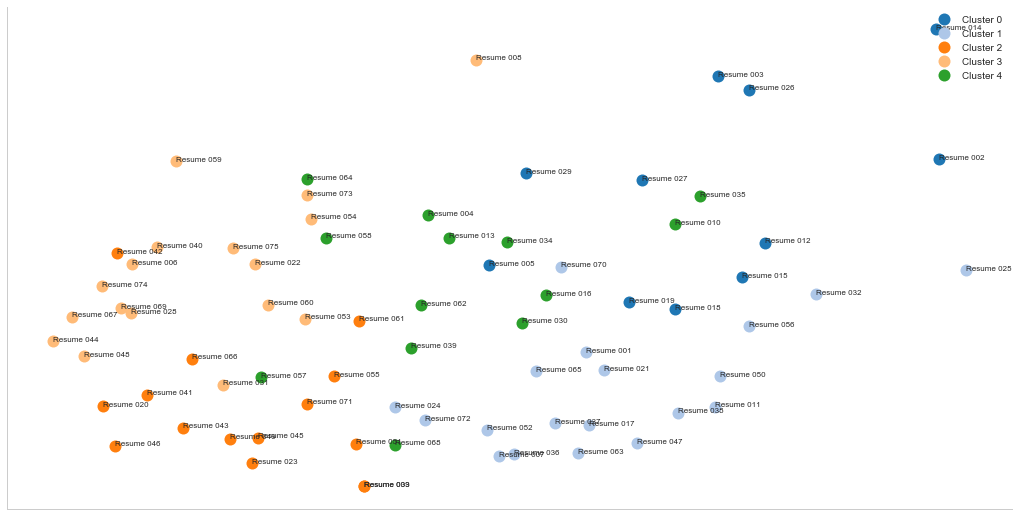

In [1168]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=resnames)) 

#group by cluster
groups = df.groupby('label')

# set up plot
fig, ax = plt.subplots(figsize=(18, 9)) # set size
sns.set_style("whitegrid")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  

plt.grid(False)
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

In [1151]:
tfidfwords = tfidf.vocabulary_
print type(tfidfwords), len(tfidfwords)

<type 'dict'> 78


In [1152]:
# (0, 61799)
# tdidfwords

for key, val in tfidfwords.items():
    if val == 3021:
        print key

In [1153]:
flat_tokens = [item for sublist in tokens for item in sublist]
flat_set = set(flat_tokens)

print len(flat_tokens), len(flat_set)

63897 8034


In [1154]:
grandset = dict.fromkeys(list(flat_set))

In [1155]:
# for i in range(2):
#     tempset = list(set(tokens[i]))
#     for j in range(len(tokens[i])):
#         print len(tokens[i]), len(tempset), tokens[i][j], tempset[j]

In [1156]:
blob = TextBlob(corpus[5])
tempnouns = blob.noun_phrases

In [1157]:
print type(tempnouns), len(tempnouns), len(set(tempnouns))

<class 'textblob.blob.WordList'> 140 123


In [1193]:
noundictionary = defaultdict(list)
resumenouns = defaultdict(list)

for i in range(75):
    blob = TextBlob(corpus[i])
    tempnouns = list(blob.noun_phrases)
    setnouns = list(set(tempnouns))
    for j in range(len(setnouns)):
        if setnouns[j] not in stopwords:
            noundictionary[setnouns[j]].append(i+1)
            resumenouns[setnouns[j]].append(i)


In [1201]:
for key, val in resumenouns.items():
    if len(val) > 11:
        print key, ': ', val

responsible :  [5, 6, 9, 10, 18, 22, 25, 26, 30, 34, 35, 36, 40, 42, 45, 46, 47, 49, 51, 52, 53, 54, 56, 59, 60, 61, 66, 67, 68, 70, 72, 73, 74]
planned :  [16, 38, 40, 41, 42, 44, 45, 58, 59, 65, 67, 73]
worked :  [7, 13, 18, 24, 25, 27, 28, 30, 31, 33, 41, 42, 44, 47, 50, 52, 65, 67]
support :  [8, 18, 19, 29, 30, 32, 33, 38, 41, 42, 45, 48, 50, 53, 67, 69]
team :  [0, 19, 20, 25, 35, 38, 42, 49, 52, 53, 59, 64, 68, 71]
central command :  [16, 20, 22, 38, 40, 46, 50, 55, 60, 61, 62, 72]
studies :  [0, 2, 10, 13, 14, 15, 16, 18, 22, 27, 28, 33, 39, 41, 43, 44, 55, 57, 58, 60, 68, 73, 74]
palantir :  [8, 10, 20, 22, 30, 32, 35, 36, 37, 44, 50, 53, 64, 69]
political science :  [0, 4, 6, 12, 15, 17, 19, 25, 27, 31, 33, 34, 40, 41, 43, 55, 65, 66]
air force :  [3, 11, 15, 17, 23, 24, 28, 31, 36, 45, 46, 47, 52, 54, 61, 62, 70, 74]
training :  [0, 5, 6, 8, 12, 14, 16, 30, 32, 35, 38, 39, 40, 41, 43, 44, 45, 49, 50, 51, 52, 53, 56, 62, 63, 68, 70, 71, 72, 74]
combined :  [0, 19, 27, 39, 40,

In [1186]:
# set(nouns.values())
temptokens = []

for key, val in noundictionary.items():
    if len(val) == 14 :
        print len(val), ': ', key
#         temptokens.append(key)

14 :  team
14 :  palantir
14 :  combined
14 :  b.a.
14 :  produced
14 :  subject matter expert
14 :  m.a.
14 :  america
14 :  management
14 :  intelligence operations
14 :  maintained
14 :  intelligence analysis
14 :  google earth
14 :  degree


In [1183]:
for i in range(end):
    temptokens
    
for i in range(75):
    blob = TextBlob(corpus[i])
    tempnouns = list(blob.noun_phrases)
    setnouns = list(set(tempnouns))
    for j in range(len(setnouns)):
        if setnouns[j] not in stopwords:
            noundictionary[setnouns[j]].append(i+1)

[u'specialist',
 u'china',
 u'dni',
 u'direct support',
 u'm.s.',
 u'law enforcement',
 u'siprnet',
 u'sme',
 u'responsible',
 u'participate',
 u'stuttgart',
 u'planned',
 u'worked',
 u'dhs',
 u'qualifications',
 u'priority intelligence requirements',
 u'information operations',
 u'meade',
 u'sof',
 u'support',
 u'years experience',
 u'useucom',
 u'gemini',
 u'and awards',
 u'senior leaders',
 u'team',
 u'central command',
 u'mentored',
 u'drafted',
 u'studies',
 u'conduct medal',
 u'working',
 u'intelligence requirements',
 u'palantir',
 u'applications',
 u'political science',
 u'cidne',
 u'nsa',
 u'honduras',
 u'air force',
 u'internet',
 u'training',
 u'citp',
 u'russia',
 u'awards',
 u'mission requirements',
 u'combined',
 u'national security agency',
 u'surveillance',
 u'lebanon',
 u'congress',
 u'sci',
 u'federal bureau',
 u'combating terrorism',
 u'computer skills',
 u'experience',
 u'information',
 u'b.a.',
 u'communication skills',
 u'major',
 u'introduction',
 u'iranian',
 u'

In [1172]:
tokencounts = defaultdict(int)

for key, val in noundictionary.items():
    tokencounts[len(val)] += 1
    

In [1173]:
tokencounts
#     if len(val) == 58:
#     print len(val), ': ', key

defaultdict(int,
            {1: 10166,
             2: 1146,
             3: 369,
             4: 206,
             5: 110,
             6: 84,
             7: 39,
             8: 32,
             9: 32,
             10: 25,
             11: 23,
             12: 13,
             13: 6,
             14: 14,
             15: 9,
             16: 5,
             17: 6,
             18: 8,
             19: 2,
             20: 2,
             21: 3,
             22: 1,
             23: 3,
             24: 1,
             25: 3,
             26: 2,
             27: 1,
             28: 2,
             29: 3,
             30: 3,
             31: 1,
             33: 2,
             40: 1,
             41: 1,
             45: 1,
             58: 1})

In [1174]:
len(noundictionary)

12326

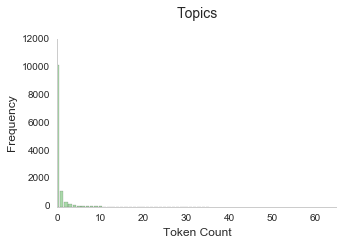

In [1175]:
plt.figure(figsize=(5,3))
sns.set_style("whitegrid")
ax = plt.subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.bar(range(len(tokencounts.values())), tokencounts.values(), 
        align = 'center', color = colors[4], alpha = 0.4, label = '')

# plt.xticks(range(len(noundictionary.values())),range(len(noundictionary.values())))
plt.xlim(0,65)
# plt.ylim(0.0,1.1)
plt.title('Topics\n', fontsize=14, fontweight='normal')
plt.xlabel('Token Count', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
     
plt.legend()
plt.grid(False)

### sklearn AgglomerativeClustering

* [Agglomerative clustering with and without structure](http://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_clustering.html)

In [107]:
X = x.toarray()
knn = 10

knn_graph = kneighbors_graph(X, knn, include_self=False)

for connectivity in (None, knn_graph):
    for n_clusters in (knn, 3):
        plt.figure(figsize=(18, 4))
        
        for index, linkage in enumerate(('average', 'complete', 'ward')):

            plt.subplot(1, 3, index + 1)
            model = AgglomerativeClustering(linkage=linkage,
                                            connectivity=connectivity,
                                            n_clusters=n_clusters)
            t0 = time.time()
            model.fit(X)
            elapsed_time = time.time() - t0
            
            plt.scatter(X[:, 0], X[:, 1], c=model.labels_, cmap=plt.cm.spectral)
            plt.title('linkage=%s (time %.2fs)' % (linkage, elapsed_time),
                      fontdict=dict(verticalalignment='top'))
            
            plt.axis('equal')
            plt.axis('off')

            plt.subplots_adjust(bottom=0, top=.89, wspace=0, left=0, right=1)
            plt.suptitle('n_cluster=%i, connectivity=%r' %
                         (n_clusters, connectivity is not None), size=17)


plt.show()

NameError: name 'x' is not defined

### sklearn DBSCAN

* [sklearn.cluster.DBSCAN](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)
* [sklearn.feature_extraction.text.CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

In [250]:
vect = CountVectorizer(input = 'content', encoding = 'utf-8', decode_error = 'strict', 
                       strip_accents = None, lowercase=True, preprocessor = None, 
                       tokenizer = tokenizenstem, stop_words = stopwords, token_pattern='(?u)\b\w\w+\b', 
                       ngram_range = (1, ngrams), analyzer = 'word', 
                       max_df = 1.0, min_df = 1, max_features = None, 
                       vocabulary = None, binary = False)

wookie = vect.fit_transform(corpus)

In [255]:
db = DBSCAN(eps=0.5, min_samples=5, metric='euclidean', 
            algorithm='auto', leaf_size=30, p=None, random_state=None).fit(wookie)

ValueError: setting an array element with a sequence.

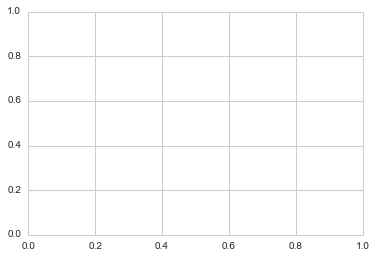

In [257]:
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

X = wookie

# Generate sample data
# centers = [[1, 1], [-1, -1], [1, -1]]
# X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4,
#                             random_state=0)

# X = StandardScaler().fit_transform(X)

# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

# print('Estimated number of clusters: %d' % n_clusters_)
# print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
# print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
# print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
# print("Adjusted Rand Index: %0.3f"
#       % metrics.adjusted_rand_score(labels_true, labels))
# print("Adjusted Mutual Information: %0.3f"
#       % metrics.adjusted_mutual_info_score(labels_true, labels))
# print("Silhouette Coefficient: %0.3f"
#       % metrics.silhouette_score(X, labels))

##############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

## sklearn Latent Dirichlet Allocation()

In [ ]:
ldamodel1 = LatentDirichletAllocation(n_topics = 20)
sklearnldamodel = ldamodel1.fit_transform(tfs)

In [ ]:
# dir(sklearnldamodel)

In [ ]:
sklearnldamodel.shape

## LDA - Topic modeling with Latent Dirichlet Allocation

In [ ]:
# import lda.datasets
# X = lda.datasets.load_reuters()
# vocab = lda.datasets.load_reuters_vocab()
# titles = lda.datasets.load_reuters_titles()

# ldamodel3 = lda.LDA(n_topics=20, n_iter=1500, random_state=1)

# ldamodel3.fit_transform(X)
# topic_word = ldamodel3.topic_word_  # model.components_ also works

# n_top_words = 8
# for i, topic_dist in enumerate(topic_word):
#     topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
#     print('Topic {}: {}'.format(i, ' '.join(topic_words)))

In [ ]:
# doc_topic = ldamodel3.doc_topic_
# for i in range(10):
#     print("{} (top topic: {})".format(titles[i], doc_topic[i].argmax()))

## LDA with Resume Data

In [40]:
vectorizer = CountVectorizer(min_df=1, ngram_range=(1, 1), stop_words = 'english', analyzer = 'word', 
                             strip_accents = None)

corpusmatrix = vectorizer.fit_transform(corpus)

words = []
for key, val in vectorizer.vocabulary_.items():
    words.append(key)
    
len(words)

7629

In [39]:
pairwise_distances(corpusmatrix, metric = 'euclidean')

NameError: name 'corpusmatrix' is not defined

In [ ]:
ldamodel2 = lda.LDA(n_topics=10, n_iter=1500, random_state=1)

ldamodel2.fit_transform(corpusmatrix)  # model.fit_transform(X) is also available
topic_word2 = ldamodel2.topic_word_  # model.components_ also works

In [ ]:
ldamodel2.topic_word_

In [ ]:
print corpusmatrix.shape, len(words), len(topic_word2), type(ldamodel2)

In [ ]:
topic_word2

In [ ]:
n_top_words = 8
for i, topic_dist in enumerate(topic_word2):
    topic_words = np.array(words)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

In [ ]:
doc_topic2 = ldamodel2.doc_topic_

resumedict = defaultdict(int)
resumedict2 = defaultdict(list)

for i in range(75):
#     print("{} (top topic: {})".format('Resume ' + str(i + 1), doc_topic2[i].argmax()))
    resumedict[doc_topic2[i].argmax()] += 1
    resumedict2[doc_topic2[i].argmax()].append(i)

In [ ]:
plt.figure(figsize=(5,3))
sns.set_style("whitegrid")
ax = plt.subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.bar(range(len(resumedict.values())), resumedict.values(),
        align = 'center', color = colors[2], alpha = 0.4, label = '')

plt.xticks(range(len(resumedict.values())),range(len(resumedict.values())))
# plt.xlim(0.0,1.1)
# plt.ylim(0.0,1.1)
plt.title('Topics\n', fontsize=14, fontweight='normal')
plt.xlabel('LDA Topic Categories', fontsize=12)
plt.ylabel('Resume Count', fontsize=12)
     
plt.legend()
plt.grid(False)

In [ ]:
resumedict

In [ ]:
resumedict2

## Create a JSON Data file

In [1171]:
# {"name":"Gillenormand","group":5},
end = 75

for i in range(end):
    filename = '0' * (3 - len(str(i + 1))) + str(i + 1)
    print '{\"name\":\"Resume ' + filename + '",\"group\":' + str(doc_topic2[i].argmax()) +'},'

NameError: name 'doc_topic2' is not defined

In [ ]:
# {"source":36,"target":11,"value":2},
from random import randint

for i in range(end):
    filename = '0' * (3 - len(str(i + 1))) + str(i + 1)
    print '{\"source\":' + str(i) + ',\"target\":' + str(randint(0,74)) + ',\"value\":' + str(randint(0,9)) + '},'